In [1]:
#@title packages
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma  # ma = masked array
import pandas as pd
import math as mt
import random
from itertools import zip_longest
from collections import Counter
import scipy.stats as stats

In [2]:
network_name = 'hep-th'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#@title preparing graph
with open('/content/drive/My Drive/Colab Notebooks/'+network_name+'.txt', 'r') as file:
    data = file.readlines()
edges = [ tuple(lines.split()[0:2]) for lines in data]
# ---------------------------------------------------------------------------

G = nx.Graph()
G.add_edges_from(edges)
G = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)
print(nx.info(G))
# plt.figure(figsize=(100,100))
# nx.draw_networkx(G)

Name: 
Type: Graph
Number of nodes: 7610
Number of edges: 15751
Average degree:   4.1396


### F(t) Value (Spreading Ability) --- F(t) = I(t) + R(r)

In [5]:
#@title sir and spreading_ability
def sir(G, plot_total_suscept, plot_total_infect, plot_total_recover, plot_timestamp, steps, node, alpha, beta):
    infected = [node]
    state = [0 for i in range(G.number_of_nodes())]
    state[node] = 1
    
    infect = [node]
    infectnew = [node]
    initial_infect = len(infected)

    total_infect = initial_infect
    total_suscept = G.number_of_nodes() - initial_infect
    total_recover = 0
    timestamp = 0
    ##### initialize
    plot_total_infect.append(total_infect)
    plot_total_suscept.append(total_suscept)
    plot_total_recover.append(total_recover)
    plot_timestamp.append(timestamp)
    
    total_infectnew = len(infected)
    total_susceptnew = G.number_of_nodes() - initial_infect;
    total_recovernew = 0
    
    while timestamp < steps:
        for inode in infect:
            if G.has_node(inode):
                for v in G.neighbors(inode):         # susceptible=0, infected=1, recovered=2
                    if state[v] == 0:
                        if random.randint(1, 100) <= alpha:
                            state[v] = 1
                            total_infectnew += 1
                            infectnew.append(v)
                            total_susceptnew -= 1

                    elif state[v] == 1:
                        if random.randint(1, 100) <= beta:
                            state[v] = 2
                            total_infectnew -= 1
                            infectnew.remove(v)
                            total_recovernew += 1
        timestamp += 1
        
        plot_total_infect.append(total_infectnew)
        plot_total_suscept.append(total_susceptnew)
        plot_total_recover.append(total_recovernew + total_infectnew)
        plot_timestamp.append(timestamp)
        
        total_infect, total_suscept, total_recover = 0, 0, 0
        infect = infectnew[:]
        total_infect = total_infectnew
        total_suscept = total_susceptnew
# =====================================================================
def spreading_ability(G, alpha, beta, iteration):
    F_t = []
    
    S, I, R, T = [], [], [], []
    for j in G.nodes:
        finalS, finalI, finalR, finalTime = [],[],[],[]
        sir(G, finalS, finalI, finalR, finalTime, iteration, j, alpha, beta)
        S.append(finalS)
        I.append(finalI)
        R.append(finalR)
        T.append(finalTime)
        
    for i in range(len(S)):
        F_t.append( I[i][-1] + R[i][-1] )
    return F_t
# =================================================================


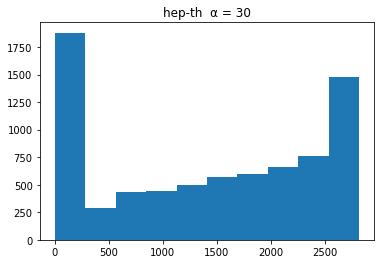

In [6]:
alpha, beta, iteration = 30, 100, 100  # infection rate, recovery rate, iteration
independent_run = 100
try:
    f = pd.read_csv('/content/drive/My Drive/Colab Notebooks/'+network_name+'_ft_'+str(alpha)+'_'+str(iteration)+'_'+str(independent_run)+'.csv')
    F_t1 = list(f.Ft)
    
except:
    F_t1 = list(np.mean( np.array( [spreading_ability(G, alpha, beta, iteration) for _ in range(independent_run)] ), axis=0 ))
    pd.DataFrame(list(zip(G.nodes, F_t1)), columns=['Node', 'Ft']).to_csv('/content/drive/My Drive/Colab Notebooks/'+network_name+'_ft_'+str(alpha)+'_'+str(iteration)+'_'+str(independent_run)+'.csv', index=False)
    
plt.hist(F_t1);
plt.title(network_name+'  \u03B1 = '+str(alpha));

In [7]:
ft = sorted(zip(G.nodes(), F_t1), key=lambda t:t[1], reverse=True)
ft = pd.DataFrame(ft, columns=['Node', 'F(t)'])
# ft.head()

### Degree Centrality   $C_d(V) = \sum_{}\frac{A_{uv}}{(n-1)}$ for u=1 to n


In [8]:
#@title Degree Centrality
# try:
#     d = pd.read_csv('/content/drive/My Drive/Colab Notebooks/'+network_name+'_dc.csv')
#     d_cen_dic = dict(d.values.tolist())
    
#     d = sorted(d_cen_dic.items(), key=lambda t:t[1], reverse=True)
#     d = pd.DataFrame(d, columns=['Node', 'DC_Rank'])
    
# except:
#     d_cen_dic = nx.degree_centrality(G)

#     pd.DataFrame(list(d_cen_dic.items()), columns=['Node', 'DC_Rank']).to_csv('/content/drive/My Drive/Colab Notebooks/'+network_name+'_dc.csv', index=False)
    
#     d = sorted(d_cen_dic.items(), key=lambda t:t[1], reverse=True)
#     d = pd.DataFrame(d, columns=['Node', 'DC_Rank'])
# # d.head()

In [9]:
#@title Degree only
try:
    d = pd.read_csv('/content/drive/My Drive/Colab Notebooks/'+network_name+'_degree.csv')
    d_cen_dic = dict(d.values.tolist())
    
    d = sorted(d_cen_dic.items(), key=lambda t:t[1], reverse=True)
    d = pd.DataFrame(d, columns=['Node', 'DC_Rank'])
    
except:
    d_cen_dic = dict(nx.degree(G))

    pd.DataFrame(list(d_cen_dic.items()), columns=['Node', 'DC_Rank']).to_csv('/content/drive/My Drive/Colab Notebooks/'+network_name+'_degree.csv', index=False)
    
    d = sorted(d_cen_dic.items(), key=lambda t:t[1], reverse=True)
    d = pd.DataFrame(d, columns=['Node', 'DC_Rank'])
# d.head()

### Closeness Centrality $C_c = \frac{1}{sum\ of\ shortest\ distance\ of\ node\ c\ to\ all\ other\ nodes}$

In [10]:
#@title
try:
    c = pd.read_csv('/content/drive/My Drive/Colab Notebooks/'+network_name+'_cc.csv')
    c_cen_dic = dict(c.values.tolist())
    
    c = sorted(c_cen_dic.items(), key=lambda t:t[1], reverse=True)
    c = pd.DataFrame(c, columns=['Node', 'CC_Rank'])

except:
    c_cen_dic = nx.closeness_centrality(G)
    pd.DataFrame(list(c_cen_dic.items()), columns=['Node', 'CC_Rank']).to_csv('/content/drive/My Drive/Colab Notebooks/'+network_name+'_cc.csv', index=False)
    
    c = sorted(c_cen_dic.items(), key=lambda t:t[1], reverse=True)
    c = pd.DataFrame(c, columns=['Node', 'CC_Rank'])
# c.head()

### Betweenness Centrality $ B_c = \sum_{u,v}(\frac{\sigma_{st}(V)}{\sigma_{st}})\ such\ that\ s\ne t \ne v$


In [11]:
#@title
try:
    b = pd.read_csv('/content/drive/My Drive/Colab Notebooks/'+network_name+'_bc.csv')
    b_cen_dic = dict(b.values.tolist())
    
    b = sorted(b_cen_dic.items(), key=lambda t:t[1], reverse=True)
    b = pd.DataFrame(b, columns=['Node', 'BC_Rank'])
    
except:
    b_cen_dic = nx.betweenness_centrality(G)
    pd.DataFrame(list(b_cen_dic.items()), columns=['Node', 'BC_Rank']).to_csv('/content/drive/My Drive/Colab Notebooks/'+network_name+'_bc.csv', index=False)
    
    b = sorted(b_cen_dic.items(), key=lambda t:t[1], reverse=True)
    b = pd.DataFrame(b, columns=['Node', 'BC_Rank'])
# b.head()

#### Combining $D_c, C_c, B_c$ to form a matrix and Normalizing

In [12]:
d_cen = list(d_cen_dic.values())
c_cen = list(c_cen_dic.values())
b_cen = list(b_cen_dic.values())
Y_D = np.array([d_cen, b_cen, c_cen]).transpose()

# Normalizing cetnrality matrix
Y_D_normalized = Y_D / ( np.sum(Y_D**2, axis=0)**(0.5) )

#### Combining $D_c, C_c, B_c, and\ F(t)$ to Form a Matrix

In [13]:
mat = np.array([d_cen, b_cen, c_cen, F_t1]).transpose()
# pd.DataFrame(mat, columns=['DC','BC','CC','F(t)']).head()

### Dynamic Weight Using W-TOPSIS

In [14]:
def dynamic_weight_TOPSIS(mat):
    D = mat    
    R = D / np.sum(D, axis=0)
    V = 1 / abs( R[:, 0:-1] - R[:, -1:] )
    e = V.sum(axis=0)
    w = e / e.sum()
    return w
    
w_topsis = dynamic_weight_TOPSIS(mat)
print("Dynamic weight using Weighted TOPSIS: ", w_topsis)

Dynamic weight using Weighted TOPSIS:  [0.00830074 0.11649544 0.87520383]


### Ranking using W-TOPSIS

In [15]:
def rank_using_W_TOPSIS(mat, w_topsis):
    M = mat[: , 0:-1]            #M is a submatrix of matrix D 
    # Normalizing M
    M = M / ( np.sum(M**2, axis=0)**(0.5) )
    B = M * w_topsis

    A_plus = np.max(B, axis=0)
    A_minus = np.min(B, axis=0)

    S_plus = (np.sum((B-A_plus)**2, axis=1))**(0.5)
    S_minus = (np.sum((B-A_minus)**2, axis=1))**(0.5)

    return S_minus/(S_minus + S_plus)
C = rank_using_W_TOPSIS(mat, w_topsis)
# print(C)

In [16]:
x_topsis_dict = dict(zip(G.nodes, C))
y_topsis = sorted(x_topsis_dict.items(), key=lambda t:t[1], reverse=True)
y_topsis = pd.DataFrame(y_topsis, columns=['Node', 'W-TOPSIS_Rank'])
# y_topsis.head(10)

### D_WSM  (W-TOPSIS and WSM)
###### here dynamic weight is calculated by W-TOPSIS and then WSM applied

In [17]:
Y_D_normalized_D_WSM = Y_D_normalized * w_topsis
x_D_WSM = Y_D_normalized_D_WSM.sum(axis=1)
x_D_WSM_dict = dict(zip(G.nodes, x_D_WSM))

y_D_WSM = sorted(x_D_WSM_dict.items(), key=lambda t:t[1], reverse=True)
y_D_WSM = pd.DataFrame(y_D_WSM, columns=['Node', 'D_WSM_Rank'])
# y_D_WSM.head(10)

## Dynamic Weight using GRA
### (1) Due to differences of measurement units, it is necessary to process each attribute into a comparability sequence. $ \ \ \ \ y_{ij} = \frac{e_{ij} - \min_{\forall i} e_{ij}} {\sum_{k=1}^N e_{kj}}$ 

## $(2) \ \ \ \ r(y_{i0}, y_{ij}) = \frac{\min_{\forall i}\min_{\forall j}|y_{i0} - y_{ij}|\ +\ \rho\max_{\forall i}\max_{\forall j}|y_{i0} - y_{ij}|}{|y_{i0} - y_{ij}|\ +\ \rho \max_{\forall i}\max_{\forall j}|y_{i0} - y_{ij}|}$
### $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ i = 1,2,...,N; \ \ \ \ j = 1,2,...,M,$

###     $\ \ \ \ \ \ \ R(Y_0, Y_j) = \frac{1}{N}\sum_{i=1}^N r(y_{0j}, y_{ij}),\ \ \ \ \  j = 1,2,...,M,$
### $\ \ \ \ \ \ \ \ \ \       where\ \rho\ is\ the\ distinguishing\ coefficient,\ \rho \in [0, 1]$

### $(3) \ \ \ \ w_j = \frac{R(Y_{M+1}, Y_j)}     { \sum_{k=1}^M  R(Y_{M+1}, Y_j) },   \ \ \  j = 1, 2, ... M$

In [18]:
def dynamic_weight_GRA(mat):    # mat = [DC, BC, CC, F(t)]
    Y = (mat - mat.min(axis=0)) / np.sum(mat, axis=0)
    roh = 0.5
    M = np.absolute( Y[ : , 0:-1] - Y[ : , -1:] )
    r = ( M.min() + roh*M.max() ) / ( M + roh*Y.max() )
    R = r.mean(axis=0)
    w = R / R.sum()
    return w

w_gra = dynamic_weight_GRA(mat)
print("Dynamic weight using GRA:  ", w_gra)
print("\nDynamic weight using Weighted TOPSIS: ", w_topsis)

Dynamic weight using GRA:   [0.33320699 0.3280414  0.33875161]

Dynamic weight using Weighted TOPSIS:  [0.00830074 0.11649544 0.87520383]


## GRA-WSM

In [19]:
# WSM is applied here
Y_D_normalized_gra = Y_D_normalized * w_gra
x_gra = Y_D_normalized_gra.sum(axis=1)
x_gra_dict = dict(zip(G.nodes, x_gra))

In [20]:
y_gra=sorted(x_gra_dict.items(), key=lambda t:t[1], reverse=True)
y_gra=pd.DataFrame(y_gra, columns=['Node', 'GRA_WSM_Rank'])
# y_gra.head(10)

In [21]:
pd.set_option('display.max_columns', None)
p = 10
line = pd.DataFrame(['|']*p, columns=['|'])
result = pd.concat([line,d.head(p),line, c.head(p),line, b.head(p),line,y_D_WSM.head(p),line, y_topsis.head(p),line, y_gra.head(p),line, ft.head(p)], axis=1, sort=False)
common_node1 = list(set(y_gra.head(p)['Node']) - set(y_topsis.head(p)['Node']))
common_node2 = list(set(y_topsis.head(p)['Node']) - set(y_gra.head(p)['Node']))
print("Node present in GRA-WSM but not in W-TOPSIS: ", common_node1 )
print("Node present in W-TOPSIS but not in GRA-WSM: ", common_node2 )
print('-'*100)
result

Node present in GRA-WSM but not in W-TOPSIS:  [561]
Node present in W-TOPSIS but not in GRA-WSM:  [511]
----------------------------------------------------------------------------------------------------


,|,Node,DC_Rank,|,Node,CC_Rank,|,Node,BC_Rank,|,Node,D_WSM_Rank,|,Node,W-TOPSIS_Rank,|,Node,GRA_WSM_Rank,|,Node,F(t)
0,|,490,50,|,191.0,0.163711,|,50.0,0.024310,|,50,0.038086,|,50,0.947084,|,490,0.095947,|,2125,2813.39
1,|,170,44,|,170.0,0.163090,|,490.0,0.022490,|,490,0.036323,|,490,0.912905,|,50,0.093764,|,508,2812.81
2,|,191,43,|,227.0,0.160925,|,272.0,0.021246,|,272,0.036269,|,272,0.898172,|,272,0.086202,|,778,2809.38
3,|,50,39,|,54.0,0.160850,|,299.0,0.020546,|,299,0.035149,|,299,0.872550,|,299,0.081046,|,502,2807.85
4,|,272,39,|,747.0,0.160636,|,54.0,0.017621,|,170,0.033279,|,54,0.788196,|,170,0.079701,|,3186,2807.69
5,|,542,36,|,756.0,0.160216,|,170.0,0.017451,|,54,0.033066,|,170,0.784654,|,54,0.074323,|,364,2807.39
6,|,54,35,|,196.0,0.159365,|,191.0,0.015510,|,191,0.031538,|,191,0.729515,|,191,0.074053,|,76,2807.08
7,|,547,35,|,223.0,0.158901,|,747.0,0.014670,|,747,0.030262,|,747,0.703768,|,747,0.064109,|,1957,2806.73
8,|,783,35,|,272.0,0.158845,|,458.0,0.014105,|,458,0.029351,|,458,0.686005,|,561,0.057546,|,2805,2805.04
9,|,299,34,|,194.0,0.158631,|,3176.0,0.013245,|,561,0.028156,|,511,0.653167,|,458,0.056813,|,56,2804.66


## SIR Test

In [22]:
#@title sir_1 and s_i_r_t
def sir_1(G, H, plot_total_infect, plot_total_suscept, plot_total_recover, plot_timestamp, steps, node, L=alpha, A=beta):
    nnodes = G.number_of_nodes()

    infected= [node]
    state = [0 for i in range(0, nnodes)]
    infect = []
    infectnew = []
    initial_infect = len(infected)

    for i in list(infected):
        state[i] = 1
        infect.append(i)
        infectnew.append(i)

    total_infect = initial_infect
    total_suscept = H.number_of_nodes() - initial_infect
    total_recover=0
    timestamp = 0
    ##### initialize
    plot_timestamp.append(timestamp)
    plot_total_infect.append(total_infect)
    plot_total_suscept.append(total_suscept)
    total_infectnew = len(infected)
    plot_total_recover.append(total_recover)
    total_susceptnew = H.number_of_nodes() - initial_infect
    total_recovernew=0

    while timestamp < steps:
        for i in infect:
            if H.has_node(i):
                for v in H.neighbors(i):
                    if (state[v] == 0):
                        P = random.randint(1, 100)
                        if (P <= L):
                            state[v] = 1
                            total_infectnew += 1
                            infectnew.append(v)
                            total_susceptnew -= 1

                    elif (state[v] == 1):
                        P = random.randint(1, 100)
                        if (P <= A):
                            state[v] = 2
                            total_infectnew -= 1
                            infectnew.remove(v)
                            total_recovernew += 1

        timestamp += 1
        plot_timestamp.append(timestamp)
        plot_total_infect.append(total_infectnew)
        plot_total_suscept.append(total_susceptnew)
        plot_total_recover.append(total_recovernew + total_infectnew)
        del infect[:]
        total_infect = 0
        total_suscept = 0
        total_recover = 0
        infect = infectnew[:]
        total_infect = total_infectnew
        total_suscept = total_susceptnew

# ==================================================================================================
def s_i_r_t(node, G, steps, alpha, beta):
    nnodes = G.number_of_nodes()
    S, I, R, T = [],[],[],[]
    for j in range(0, 100):
        finalS, finalI, finalR, finalTime = [],[],[],[]
        sir_1(G, G, finalI, finalS, finalR, finalTime, steps, node, alpha, beta)
        S.append(finalS)
        I.append(finalI)
        R.append(finalR)
        T.append(finalTime)
        
    finalS = [np.ma.average(ma.masked_values(temp_list, None)) for temp_list in zip_longest(*S)]
    finalI = [np.ma.average(ma.masked_values(temp_list, None)) for temp_list in zip_longest(*I)]
    finalR = [np.ma.average(ma.masked_values(temp_list, None)) for temp_list in zip_longest(*R)]
    finalTime = [np.ma.average(ma.masked_values(temp_list, None)) for temp_list in zip_longest(*T)]

    return [finalS, finalI, finalR, finalTime]

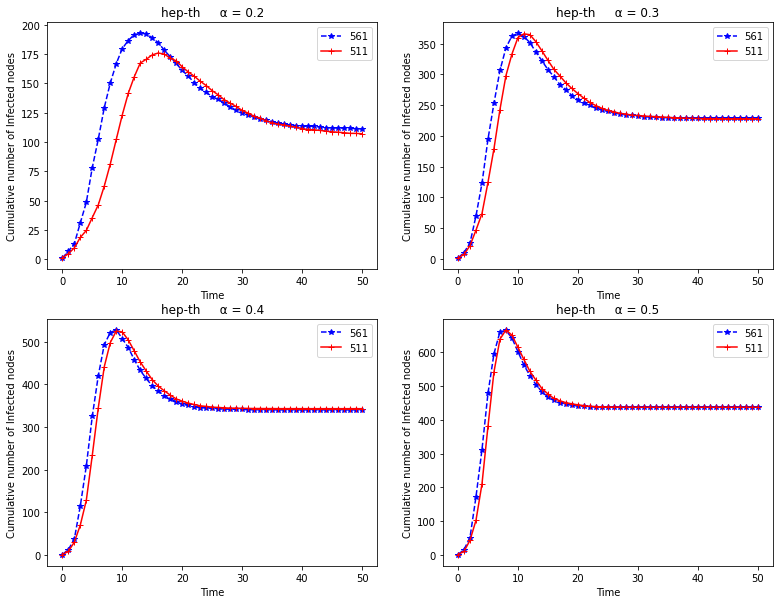

In [23]:
def plot_sir_of_nodes(node1, node2, alpha, beta, iteration):
    fig, axes = plt.subplots(2,2, figsize=(13,10))
    j=0
    for i in alpha:

        S_I_R_T = s_i_r_t(node1, G, iteration, i, beta)  #(node, G, steps)
        u = S_I_R_T[1]  # no of infected nodes
        v = list(map(int, S_I_R_T[3]))  # time (1 to 20)
        
        S_I_R_T = s_i_r_t(node2, G, iteration, i, beta)
        m = S_I_R_T[1]  # no of infected nodes
        n = list(map(int, S_I_R_T[3]))  # time (1 to 20)

    #     plt.figure(figsize=(7,5))
        axes[j//2][j%2].plot(v, u, 'b*--', label=node1)
        axes[j//2][j%2].plot(n, m, 'r-+', label=node2)

        axes[j//2][j%2].set_xlabel('Time')
        axes[j//2][j%2].set_ylabel('Cumulative number of Infected nodes')
        axes[j//2][j%2].title.set_text(network_name + '     ' + '\u03B1 = ' + str(i/100))
#         axes[j//2][j%2].set_xticks(v)
        
        axes[j//2][j%2].legend()
        j+=1
# ===========================================================================
for i in range(len(common_node1)):
    node1 = common_node1[i]
    node2 = common_node2[i]
#   ---------------------------------------------------------------
    alpha, beta, iteration = [20, 30, 40, 50], 100, 50

    plot_sir_of_nodes(node1, node2, alpha, beta, iteration)

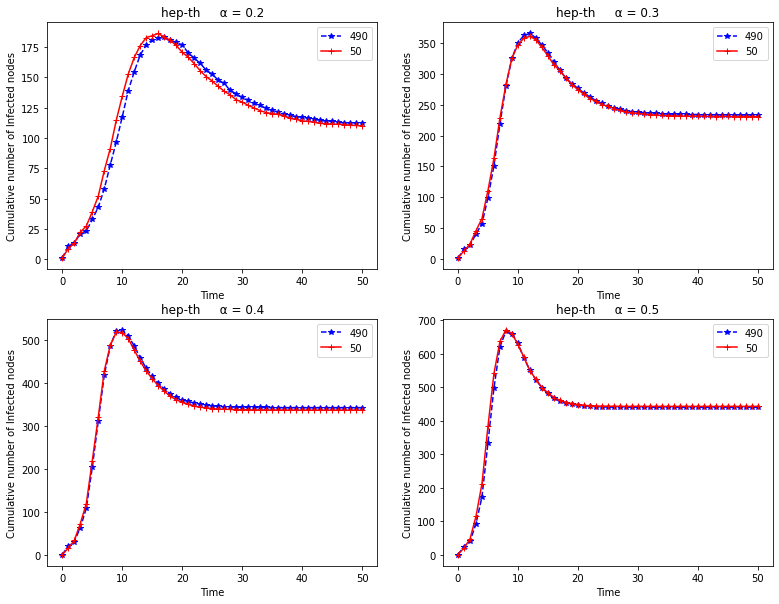

In [24]:
node1 = 490
node2 = 50
# --------------------------------------------------------------------------
alpha, beta, iteration = [20, 30, 40, 50], 100, 50

plot_sir_of_nodes(node1, node2, alpha, beta, iteration)

# Kendle Tau   $\tau = \frac{N_c - N_d}{n(n-1)/2}$ where
$N_c$ = Concordant pairs<br>
$N_d$ = Concordant pairs<br>
$n$ = number of nodes

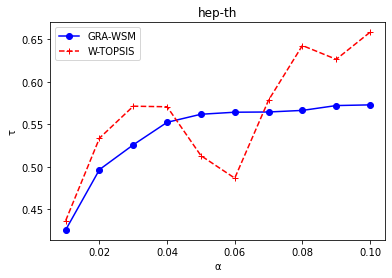

In [25]:
# Kendal Tau using spreadig_ability        alpha = [0.01 to 0.1]

alpha, beta, iteration = np.linspace(0.01, 0.1, 10), 100, 100

T1, T2, T3 = [], [], []        # tau for GRA, W_TOPSIS and D-WSM respectively
for i in alpha:
    independent_run = 10
    try:
        f = pd.read_csv('/content/drive/My Drive/Colab Notebooks/'+network_name+'_ft_'+str(round(i*100, 2))+'_'+str(iteration)+'_'+str(independent_run)+'.csv')
        F_t2 = list(f.Ft)
    except:
        
        F_t2 = list(np.mean( np.array( [spreading_ability(G, i*100, beta, iteration) for _ in range(independent_run)] ), axis=0 ))
        pd.DataFrame(list(zip(G.nodes, F_t2)), columns=['Node', 'Ft']).to_csv('/content/drive/My Drive/Colab Notebooks/'+network_name+'_ft_'+str(round(i*100, 2))+'_'+str(iteration)+'_'+str(independent_run)+'.csv', index=False)
  
    mat = np.array([d_cen, b_cen, c_cen, F_t2]).transpose()
    
    # GRA-WSM (GRA + WSM)
    w_gra = dynamic_weight_GRA(mat)  # dunamic weight using GRA
    Y_D_normalized_gra = Y_D_normalized * w_gra
    x_gra = Y_D_normalized_gra.sum(axis=1)  # GRA Rank
    tau, p_value = stats.kendalltau(F_t2, x_gra)
    T1.append(tau)
    
    # W-TOPSIS
    w_topsis= dynamic_weight_TOPSIS(mat)  # dynamic weight using W-TOPSIS
    C = rank_using_W_TOPSIS(mat, w_topsis)  # W-TOPSIS rank
    tau, p_value = stats.kendalltau(F_t2, C)
    T2.append(tau)
    
    # D-WSM  (TOPSIS + WSM)l
    Y_D_normalized_D_WSM = Y_D_normalized * w_topsis
    x_D_WSM = Y_D_normalized_D_WSM.sum(axis=1)
    tau, p_value = stats.kendalltau(F_t2, x_D_WSM)
    T3.append(tau)

plt.plot(alpha, T1, marker='o', color='b', label='GRA-WSM')
plt.plot(alpha, T2, marker='+', color='r', linestyle='--', label='W-TOPSIS')
# plt.plot(alpha, T3, marker='.', label='D-WSM')

plt.xlabel('\u03B1')
plt.ylabel('\u03C4')
plt.title(network_name)
# plt.xticks(alpha)
plt.legend()
plt.show()